# Deep Thought

#### "I think the problem, to be quite honest with you is that you've never actually known what the question was."

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here the aim is to address the weaknesses in the neural network architecture used in the [Machine Augmented Classification notebook](https://nbviewer.jupyter.org/github/dwright04/machine_augmented_classification/blob/master/Machine_Augmented_Classification.ipynb).  The name (Deep Thought) is motivated by the fact that in the first place we don't need to know the best questions to ask at the outset.

There we discussed clustering the data, then querying volunteers for a meaning or label for each cluster.  We then train a CNN only on the data that was assigned a label.  The objective of the CNN is then to optimise the categorical cross entropy loss:

$$-\sum_{i}{} \hat{y}_{i}log(y_{i})$$

where $\hat{y}_{i}$ is the target or label for the i-th subject provided to the CNN and $y_{i}$ is the CNN predicted probability for that class.

In [2]:
def categorical_cross_entropy(y_true, y_pred):
    return -np.sum(y_true*np.log(y_pred))

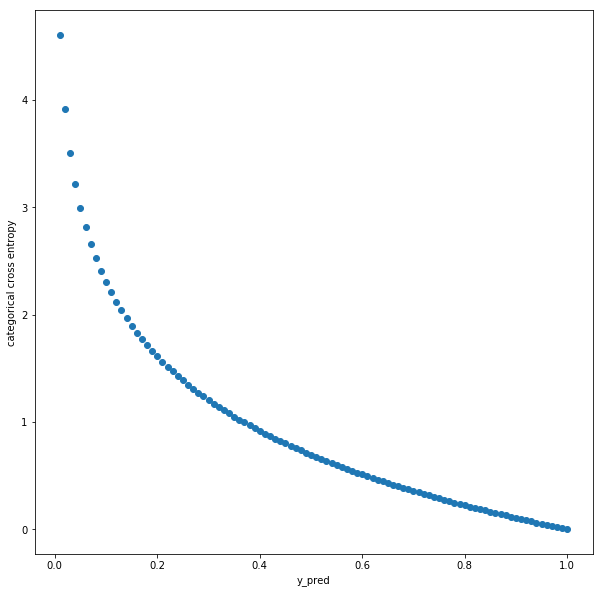

In [3]:
y_true = 1 # target/label provided to the CNN
y_preds = np.arange(0.01,1.01,0.01) # range of CNN predictions
cost = []
for y_pred in y_preds:
  cost.append(categorical_cross_entropy(y_true, y_pred))
plt.figure(figsize=(10,10))
plt.plot(y_preds, cost, 'o')
plt.ylabel('categorical cross entropy')
plt.xlabel('y_pred')
plt.show()

The categorical cross entropy is minimised when the output of the network is close to the target value (label).  All the layers of the CNN prior to the output layer learn a new representation of the data such that the classifiation layer can predict a value as close to the target as possible.

There are a couple of problems with this:

1) By asking volunteers to assign one of a predefined set of labels to a cluster the CNN must learn a representation that can combine clusters lying in different regions of feature space.


2) The network only learns about labelled subjects.  For example, previously the CNN knows nothing about subjects assigned to a meaningless/dissolved cluster.  The learned representation is not necessarily improved in a useful way for these subjects.

### Replicate some of the MNIST analysis here for illustration

In [4]:
from keras.datasets import mnist
 
# Load pre-shuffled MNIST data into train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# flatten the images for clustering
x_train_flattened = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

# limit the number of examples to 10000 to spend up this test
x_train = x_train[:10000]
x_train_flattened = x_train_flattened[:10000]
y_train = y_train[:10000]

Using TensorFlow backend.


In [5]:
from sklearn.cluster import AgglomerativeClustering

In [6]:
n_clusters = 100
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering.fit(x_train_flattened)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=100,
            pooling_func=<function mean at 0x1066a3950>)

In [7]:
from keras.utils import np_utils

one_hot_encoded = np_utils.to_categorical(y_train, 10)

stdevs = []
sizes = []
dominant_cluster_class_fractions = []
for cluster in range(n_clusters):
  cluster_indices = np.where(clustering.labels_ == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  dominant_cluster_class = np.argmax(cluster_label_fractions)
  sizes.append(n_assigned_examples)
  stdevs.append(np.std(x_train[cluster_indices]))
  dominant_cluster_class_fractions.append(cluster_label_fractions[dominant_cluster_class])

So far we have clustered the data based on the raw pixels.  Lets compare the number of examples assigned to a cluster compared to the variance of the cluster.  A smaller variance could imply a more tightly defined meaning for that cluster.

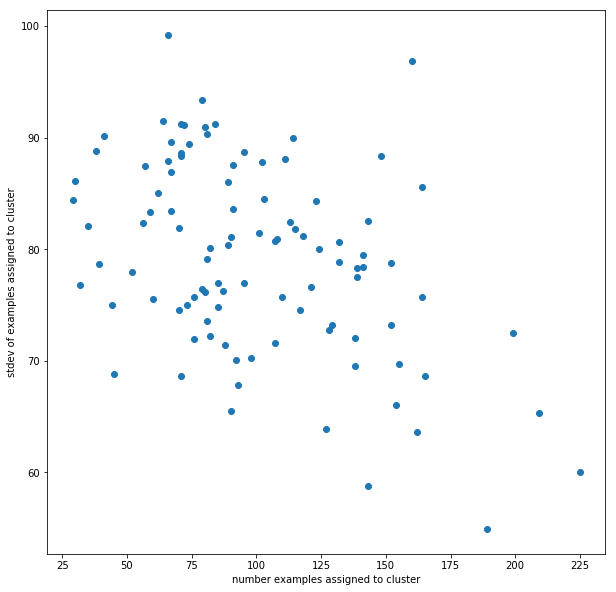

In [8]:
plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(sizes, stdevs)
plt.xlabel('number examples assigned to cluster')
plt.ylabel('stdev of examples assigned to cluster')
plt.show()

Larger clusters do tend to have a smaller variance.  This is a useful idea.

Intuitively it seems that optimising the learned representation of a CNN for cluster variance might be a good idea.  The CNN need no longer learn that clusters in different regions of feature space must be assigned the same class label.  We could optimise for a feature space that forces subjects in a meaningful cluster closer together.  Analogous to telling someone they have a great idea and should hold on to it ;)

Get the *euclidean* distances of all subjects not in cluster 5 (which has standard deviation 65.3) from the mean of cluster 5.

In [9]:
K=5
print('cluster 5 standard deviation = ' + str(stdevs[K]))
try:
  del X
except NameError:
  pass

for cluster in range(n_clusters):
  cluster_indices = np.where(clustering.labels_ == cluster)[0]
  if cluster == K:
    K_mean = np.mean(x_train_flattened[cluster_indices], axis=0)
    continue
  x = x_train_flattened[cluster_indices]
  try:
    X = np.concatenate((X,x))
  except NameError:
    X = x

cluster 5 standard deviation = 65.3062647264


In [10]:
import numpy.linalg as linalg 

Plot the distribution of *euclidean* distances of subjects in cluster 5 from the mean of the cluster.

[ 2628.22426955  3162.10679989  2984.41961812 ...,  2579.48358812
  2406.50180558  2317.07582742]


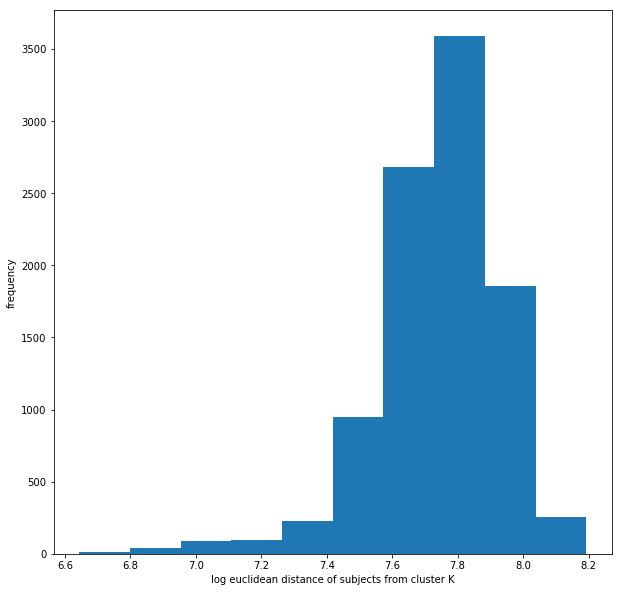

In [11]:
k_mean_euclidean_distances = linalg.norm(K_mean-X, axis=1)
print(k_mean_euclidean_distances)
plt.figure(figsize=(10,10))
plt.hist(np.log(k_mean_euclidean_distances))
plt.xlabel('log euclidean distance of subjects from cluster K')
plt.ylabel('frequency')
plt.show()

Now do the same for cluster 52 with standard deviation 99.2

In [12]:
K=52
print('cluster 52 standard deviation = ' + str(stdevs[K]))
try:
  del X
except NameError:
  pass

for cluster in range(n_clusters):
  cluster_indices = np.where(clustering.labels_ == cluster)[0]
  if cluster == K:
    K_mean = np.mean(x_train_flattened[cluster_indices], axis=0)
    continue
  x = x_train_flattened[cluster_indices]
  try:
    X = np.concatenate((X,x))
  except NameError:
    X = x

cluster 52 standard deviation = 99.1879284883


[ 1716.55345644  1943.80373254  2151.95551922 ...,  2634.68988671
  2739.583901    2782.82605088]


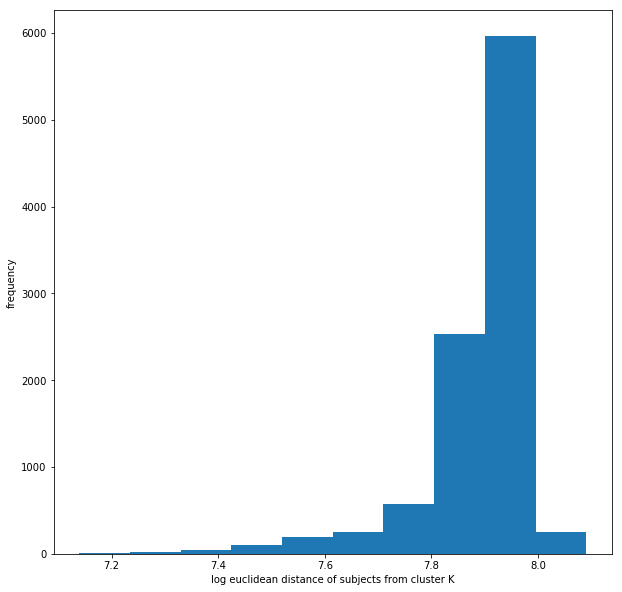

In [13]:
k_mean_euclidean_distances = linalg.norm(K_mean-X, axis=1)
print(k_mean_euclidean_distances)
plt.figure(figsize=(10,10))
plt.hist(np.log(k_mean_euclidean_distances))
plt.xlabel('log euclidean distance of subjects from cluster K')
plt.ylabel('frequency')
plt.show()

The means of the two clusters appear to be a similar distance from all subjects not in the cluster.  This would be difficult for a CNN to optimise because the vast majority of subjects look the same from the euclidean distance perspective.  The reason for this is that euclidean distance becomes less meaningufl as the dimensionality of the data increases.

https://www.youtube.com/watch?v=u0z6hs0_iV8&index=2&list=PLTrfCHV_YfzwH-tw5iUgPGzbfqdLwU0UO

### Aside : Euclidean distance in high dimensional space.

To demonstrate this consider the volume enclosed by the N-ball with radius R in n-dimensional space compared to the volume of the hyper cube enclosing it with vertices of length 2R.

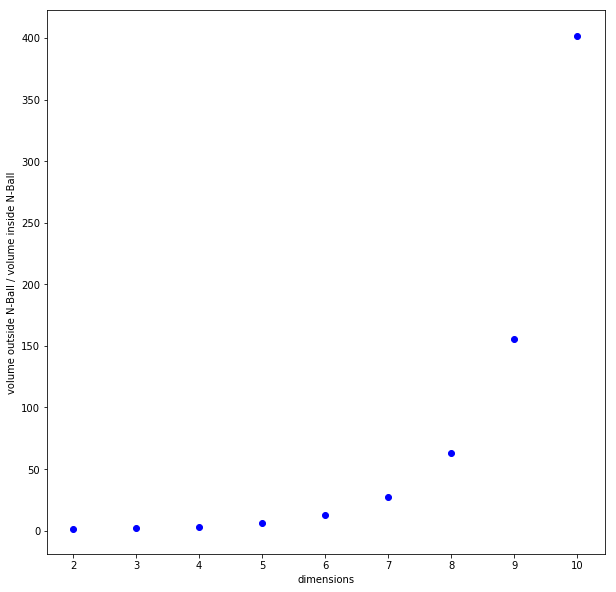

In [14]:
from scipy.special import gamma

def calculateNBallVolume(n, R=2):
  return (np.power(np.pi, n/2.)/(gamma((n/2.)+1)))*np.power(R,n)

def calculateHyperCubeVolume(n, R=2):
  return np.power(2*R,n)

plt.figure(figsize=(10,10))
for n in range(2,11):
  plt.scatter(n, calculateHyperCubeVolume(n) / calculateNBallVolume(n), color='b')
plt.xlabel('dimensions')
plt.ylabel('volume outside N-Ball / volume inside N-Ball')
plt.show()

As dimensionality increases the volume outside the sphere grows much more quickly and data points appear more equidistant.  Consider the same data projects in to 3 dimensions.

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=3)
x_train_flattened_pca = pca.fit_transform(x_train_flattened)

In [17]:
from keras.utils import np_utils

one_hot_encoded = np_utils.to_categorical(y_train, 10)

stdevs = []
sizes = []
dominant_cluster_class_fractions = []
for cluster in range(n_clusters):
  cluster_indices = np.where(clustering.labels_ == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  dominant_cluster_class = np.argmax(cluster_label_fractions)
  sizes.append(n_assigned_examples)
  stdevs.append(np.std(x_train[cluster_indices]))
  dominant_cluster_class_fractions.append(cluster_label_fractions[dominant_cluster_class])
  #print(cluster, n_assigned_examples, dominant_cluster_class, cluster_label_fractions[dominant_cluster_class])
    

Plot the euclidean distance of the mean of cluster 5 from all subjects not in cluster 5 again.

In [18]:
try:
  del X
except NameError:
  pass

K=5
for cluster in range(n_clusters):
  cluster_indices = np.where(clustering.labels_ == cluster)[0]
  if cluster == K:
    K_mean = np.mean(x_train_flattened_pca[cluster_indices], axis=0)
    continue
  x = x_train_flattened_pca[cluster_indices]
  try:
    X = np.concatenate((X,x))
  except NameError:
    X = x

[ 1884.4157084   2516.12121042  2033.78751134 ...,  1558.23312408
  1492.31644314  1509.55468823]


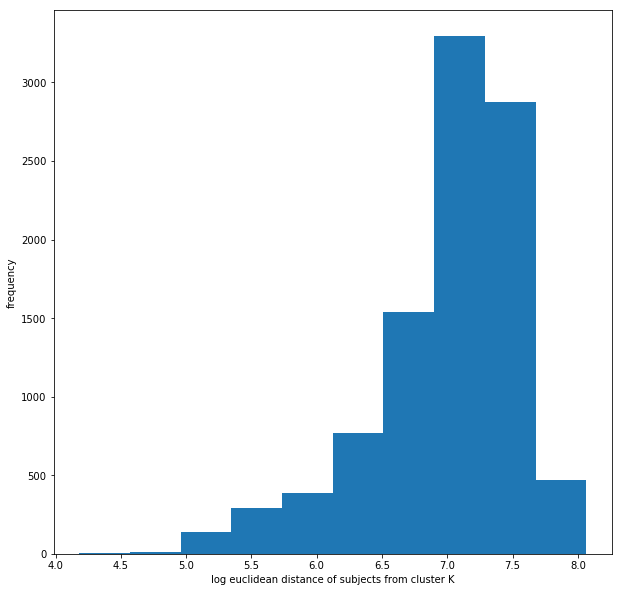

In [19]:
k_mean_euclidean_distances = linalg.norm(K_mean-X, axis=1)
print(k_mean_euclidean_distances)
plt.figure(figsize=(10,10))
plt.hist(np.log(k_mean_euclidean_distances))
plt.xlabel('log euclidean distance of subjects from cluster K')
plt.ylabel('frequency')
plt.show()

The distances now span 4 orders of magnitude compared to 1 in 400-dimensional space.

And again for cluster 52.

In [20]:
try:
  del X
except NameError:
  pass

K=52
for cluster in range(n_clusters):
  cluster_indices = np.where(clustering.labels_ == cluster)[0]
  if cluster == K:
    K_mean = np.mean(x_train_flattened_pca[cluster_indices], axis=0)
    continue
  x = x_train_flattened_pca[cluster_indices]
  try:
    X = np.concatenate((X,x))
  except NameError:
    X = x

[  585.46038875   438.96654194   347.85114371 ...,  1355.91271972
  1614.17366293  1772.28399376]


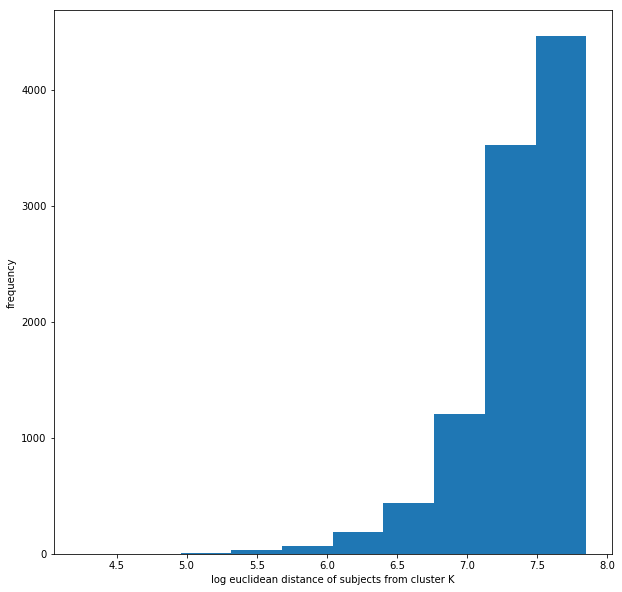

In [21]:
k_mean_euclidean_distances = linalg.norm(K_mean-X, axis=1)
print(k_mean_euclidean_distances)
plt.figure(figsize=(10,10))
plt.hist(np.log(k_mean_euclidean_distances))
plt.xlabel('log euclidean distance of subjects from cluster K')
plt.ylabel('frequency')
plt.show()

## Mahalanobis  distance

Below is work in progress. The idea is to define a cost function that is optimised to reduce the *Mahalanobis* distance between incluster points and to increase the inter cluster distance.  This is similar to the cost function of Linear Disriminant Analysis (LDA).  I am modifying it here to also treat subjects in meaningless clusters as individual clusters themselves.  This is waht I have so far.  Though it likely makes more sense to treat subjects in meaningless clusters slightly differently by ensuring that the distance between them is increased, but the distance from meaning clusters is not penalised.

Note: inter-cluster distance is defined as the distance from the mean of all the data.  (This should likely also be modified).

https://www.youtube.com/watch?v=2l5lKrU8iMA&list=PLTrfCHV_YfzwH-tw5iUgPGzbfqdLwU0UO&index=5

In [22]:
from scipy.linalg import eigh, det
# y_true is the cluster assignments, -1 if cluster has no meaning.
# y_pred logits of the output layer.
def custom_objective(y_true, y_pred):
  labels = np.unique(y_true)[1:] # get all meaningful clusters
  total_mean = np.mean(y_pred, axis=0)[np.newaxis] #get the mean of the entire data set
  in_cluster_cost = 0
  between_cluster_cost = 0
  # for each meaningful cluster (here labels <=> clusters) calculate the in cluster cost and inter-cluster cost 
  for label in labels:
    cluster_mean = np.mean(y_pred[np.where(y_true==label)], axis=0)[np.newaxis]
    cluster_scatter = np.dot((y_pred[np.where(y_true==label)]-cluster_mean).T,(y_pred[np.where(y_true==label)]-cluster_mean))
    in_cluster_cost += cluster_scatter
    n = np.where(y_true==label)[0].shape[0]
    between_cluster_cost += n*np.dot((cluster_mean-total_mean).T,(cluster_mean-total_mean))
  # for each unassigned subject add it's inter-cluster distance to the inter-cluster cost
  for i in range(y_true.shape[0]):
    if y_true[i] == -1:
      between_cluster_cost += np.dot((y_pred[i]-total_mean).T, (y_pred[i]-total_mean))
  eigvals, eigvecs = eigh(in_cluster_cost, between_cluster_cost, eigvals_only=False)
  # replicate the LDA cost function, but take the inverse as we want to minimise not maximise
  cost =  det(np.dot(np.dot(eigvecs.T, in_cluster_cost), eigvecs)) \
        / det(np.dot(np.dot(eigvecs.T, between_cluster_cost), eigvecs))
  return cost

Mock up some data.

In [23]:
# below represents the output of the CNN.  8 subjects have been projected into some feature space
y_pred = np.random.random((8,2))
print(y_pred)
# below represents the cluster result of clustering and querying volunteers.
# subjects 1 and 2 don't belong to a meaningful cluster
# subjects 3 and 4 belong to a meaningful cluster which has been labelled 0
# subjects 5 to 8 belong to a meaningful cluster which has been labelled 1
y_true = np.array([-1,-1,0,0,1,1,1,1])
print(y_true)

[[ 0.70102759  0.53790198]
 [ 0.36204868  0.17393892]
 [ 0.00114417  0.2888707 ]
 [ 0.77351608  0.62439019]
 [ 0.3642258   0.04504367]
 [ 0.90460141  0.99070312]
 [ 0.69283559  0.01640751]
 [ 0.12300966  0.74275005]]
[-1 -1  0  0  1  1  1  1]


Lets test the cost function.  The subjects have been (artificially) clustered despite being randomly distributed in the feature space so the cost should be high.

In [24]:
custom_objective(y_true, y_pred)

114.87508584182805

Now lets manually improve the scatter in the subjects belonging to cluster 0.  By setting these subjects to the same position in the feature space the cost should decrease.

In [25]:
y_pred_improved = y_pred.copy()

In [26]:
indices_zeros = np.where(y_true==0)[0]
y_pred_improved[indices_zeros] = 0
print(y_pred_improved)

[[ 0.70102759  0.53790198]
 [ 0.36204868  0.17393892]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.3642258   0.04504367]
 [ 0.90460141  0.99070312]
 [ 0.69283559  0.01640751]
 [ 0.12300966  0.74275005]]


In [27]:
custom_objective(y_true, y_pred_improved)

30.960574637840622

Try that again for examples in cluster 1.  There are more subjects in cluster 1 so the cost should be lower again.

In [28]:
y_pred_improved = y_pred.copy()

In [29]:
indices_zeros = np.where(y_true==1)[0]
y_pred_improved[indices_zeros] = 0
print(y_pred_improved)

[[ 0.70102759  0.53790198]
 [ 0.36204868  0.17393892]
 [ 0.00114417  0.2888707 ]
 [ 0.77351608  0.62439019]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


In [30]:
custom_objective(y_true, y_pred_improved)

-1.5965242740415756e-16

Now what happens if we increase the distance between subjects not assigned to a meaningful cluster i.e. subjects 1 and 2

In [31]:
y_pred_improved = y_pred.copy()

In [32]:
indices_zeros = np.where(y_true==-1)[0]
y_pred_improved[indices_zeros,0] = -1
y_pred_improved[indices_zeros,1] = 1
print(y_pred_improved)

[[-1.          1.        ]
 [-1.          1.        ]
 [ 0.00114417  0.2888707 ]
 [ 0.77351608  0.62439019]
 [ 0.3642258   0.04504367]
 [ 0.90460141  0.99070312]
 [ 0.69283559  0.01640751]
 [ 0.12300966  0.74275005]]


In [33]:
custom_objective(y_true, y_pred_improved)

62.071670933233776

Now decrease the distance between subjects 1 and 2, this should increase the cost.

In [34]:
y_pred_improved[indices_zeros,:] = 0
print(y_pred_improved)

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.00114417  0.2888707 ]
 [ 0.77351608  0.62439019]
 [ 0.3642258   0.04504367]
 [ 0.90460141  0.99070312]
 [ 0.69283559  0.01640751]
 [ 0.12300966  0.74275005]]


In [35]:
custom_objective(y_true, y_pred_improved)

57.481331478868405

Lets try it out the MNIST clustering

In [36]:
custom_objective(clustering.labels_, x_train_flattened_pca)

0.01929167158971025

Dissolve clusters with < 90% dominant class cluster membership

In [37]:
labels = clustering.labels_
labels[np.where(np.array(dominant_cluster_class_fractions)<.9)] = -1

In [38]:
print(labels)

[41 82 -1 ..., 96 47 45]


In [39]:
custom_objective(labels, x_train_flattened_pca)

0.018128626399168363